In [1]:
pip install numpy pandas tslearn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.3 MB/s eta 0:00:00


In [7]:
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
from tslearn.metrics import dtw
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten

In [5]:
# 1. 데이터 로드
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.ravel()
X_test = df_X_test.values
y_test = df_y_test.values.ravel()

모델 성능 평가:
정확도: 0.6585
F1-Score: 0.7748
Recall: 0.9582
혼동 행렬 (Confusion Matrix):
[[ 61 271]
 [ 22 504]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


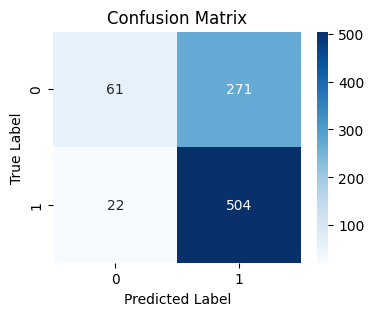

In [13]:
# DTW 거리 계산 함수
def calculate_dtw_distance(X, y):
    distances = []
    for i in range(len(X)):
        for j in range(len(X)):
            if y[i] != y[j]:  # 서로 다른 클래스 간의 거리만 계산
                distance = dtw(X[i], X[j])
                distances.append((i, j, distance))
    return distances

# DTW 거리 계산
dtw_distances = calculate_dtw_distance(X_train, y_train)

# dangerous 소수 클래스 식별 및 SMOTE 적용
def identify_dangerous_classes(X, y, dtw_distances):
    dangerous_classes = set()  # dangerous 클래스를 저장할 집합

    for i in range(len(X)):
        if y[i] == 1:  # 소수 클래스 인덱스 (가정: 1이 소수 클래스)
            # 다수 클래스의 개수를 세기 위해 가까운 거리의 샘플 찾기
            neighbors = [j for _, j, _ in dtw_distances if _ == i]
            if neighbors:
                closest_classes = y[neighbors]
                majority_count = np.sum(closest_classes == 0)  # 다수 클래스의 개수 (가정: 0이 다수 클래스)

                # 가까운 이웃 중 다수 클래스가 더 많으면 dangerous 클래스로 분류
                if majority_count > len(closest_classes) / 2:
                    dangerous_classes.add(i)

    return list(dangerous_classes)  # set에서 list로 변환

dangerous_indices = identify_dangerous_classes(X_train, y_train, dtw_distances)

# 소수 클래스 주변의 다수 클래스 샘플을 기반으로 SMOTE 적용
def apply_borderline_smote_dangerous(X, y, dangerous_indices):
    smote = BorderlineSMOTE(sampling_strategy='auto', random_state=42)

    # dangerous 소수 클래스 인덱스 찾기
    X_dangerous = X[dangerous_indices]
    y_dangerous = y[dangerous_indices]

    # SMOTE 적용
    X_resampled, y_resampled = smote.fit_resample(X_dangerous, y_dangerous)

    return X_resampled, y_resampled

# dangerous 소수 클래스를 기반으로 SMOTE 적용
if dangerous_indices:  # dangerous 소수 클래스가 존재할 경우
    X_synthetic, y_synthetic = apply_borderline_smote_dangerous(X_train, y_train, dangerous_indices)

# 예측 및 성능 평가를 위한 모델 정의 및 학습
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

# 모델 및 예측
pred_y = predict_with_logistic_regression(X_synthetic, y_synthetic, X_test)

# 성능 평가
accuracy = accuracy_score(y_test, pred_y)
recall = recall_score(y_test, pred_y)
f1 = f1_score(y_test, pred_y)
conf_matrix = confusion_matrix(y_test, pred_y)

# 성능 지표 출력
print("모델 성능 평가:")
print(f"정확도: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print("혼동 행렬 (Confusion Matrix):")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Logistic Regression 모델 성능:
모델 성능 평가:
정확도: 0.6585
F1-Score: 0.7748
Recall: 0.9582
specificity: 0.1837
혼동 행렬 (Confusion Matrix):
[[ 61 271]
 [ 22 504]]


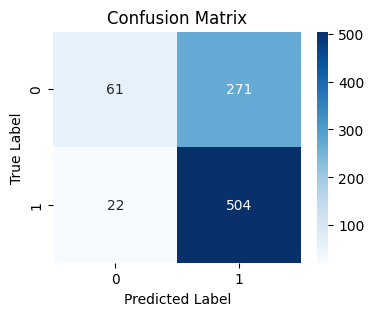

CART 모델 성능:
모델 성능 평가:
정확도: 0.7063
F1-Score: 0.7984
Recall: 0.9487
specificity: 0.3223
혼동 행렬 (Confusion Matrix):
[[107 225]
 [ 27 499]]


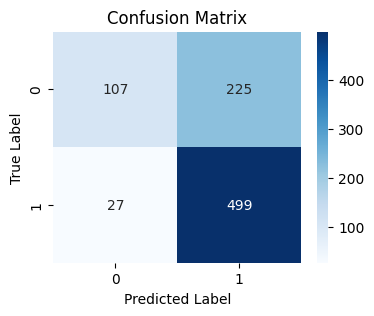

KNN 모델 성능:
모델 성능 평가:
정확도: 0.6538
F1-Score: 0.7775
Recall: 0.9867
specificity: 0.1265
혼동 행렬 (Confusion Matrix):
[[ 42 290]
 [  7 519]]


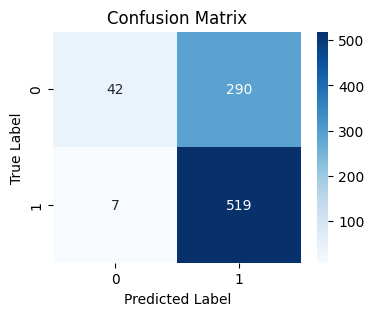

XGBoost 모델 성능:
모델 성능 평가:
정확도: 0.6434
F1-Score: 0.7740
Recall: 0.9962
specificity: 0.0843
혼동 행렬 (Confusion Matrix):
[[ 28 304]
 [  2 524]]


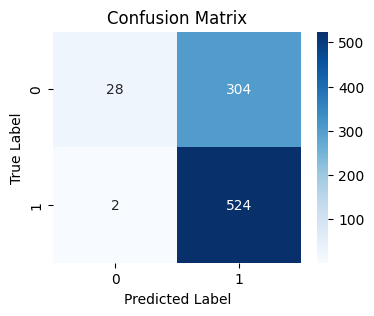

LSTM 모델 성능:
모델 성능 평가:
정확도: 0.6608
F1-Score: 0.7800
Recall: 0.9810
specificity: 0.1536
혼동 행렬 (Confusion Matrix):
[[ 51 281]
 [ 10 516]]


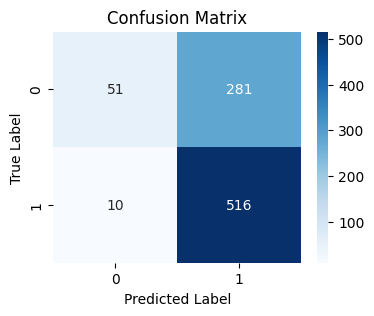

CNN 모델 성능:
모델 성능 평가:
정확도: 0.6445
F1-Score: 0.7719
Recall: 0.9810
specificity: 0.1114
혼동 행렬 (Confusion Matrix):
[[ 37 295]
 [ 10 516]]


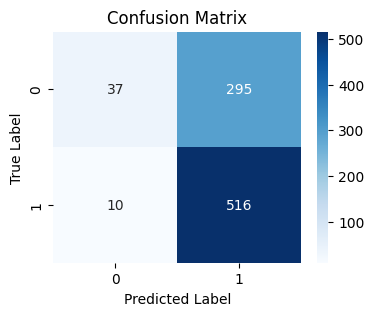

In [14]:
# 4. 예측 함수 정의
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 데이터 차원 변경
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

from imblearn.metrics import specificity_score
# 성능 평가
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    # 성능 지표 출력
    print(f"{model_name} 모델 성능:")
    print("모델 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
!pip install scikit-learn

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


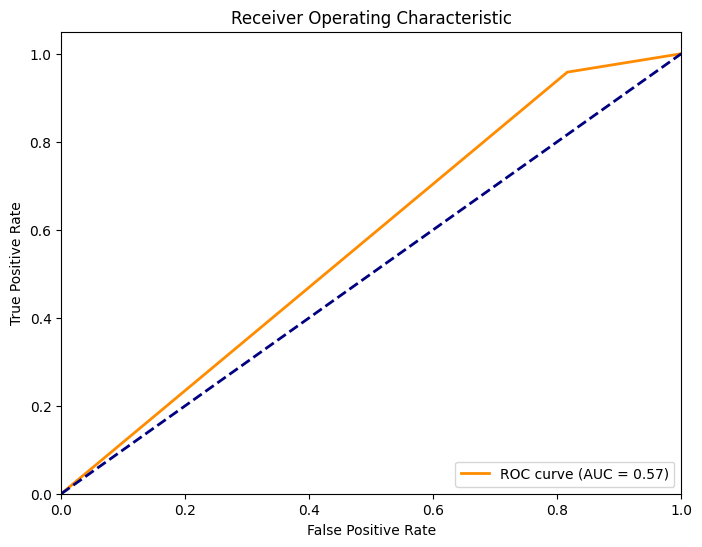

In [22]:
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc
# Assuming 'predict_with_logistic_regression' or similar function is defined and returns probabilities
y_pred_proba = predict_with_logistic_regression(X_synthetic, y_synthetic, X_test)
# 12. ROC 커브 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화 (선택 사항)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()